<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Network_classification_histology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [2]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [17]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.85, svd_solver='full')

In [21]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.85, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [23]:
train_data_stand_pca.shape

(131, 7)

#Building Network

In [0]:
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(4, activation='relu', input_shape=(7,)))
  #model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.001, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [30]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

10

In [31]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   8  10  11  12  13  14  15  16  17  18  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  46  47  48  49  50  51  52  55  56  57  58  59  60
  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78  79
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96  97  98  99
 100 101 102 103 104 106 107 108 109 110 113 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130] TEST: [  7   9  19  28  45  53  54  66  80  95 105 111 112 114]
TRAIN: [  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  45  46  47  48  49  50  52  53  54  55  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117
 118 119

In [32]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [36]:
num_epochs = 100
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history = history.history['acc']
  all_acc_histories.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 117 samples, validate on 14 samples
Epoch 1/100





117/117 [==============================] - 1s 4ms/step - loss: 2.7214 - acc: 0.2906 - val_loss: 1.4189 - val_acc: 0.3571
Epoch 2/100
117/117 [==============================] - 0s 286us/step - loss: 2.5103 - acc: 0.2906 - val_loss: 1.3321 - val_acc: 0.3571
Epoch 3/100
117/117 [==============================] - 0s 188us/step - loss: 2.3206 - acc: 0.2821 - val_loss: 1.2623 - val_acc: 0.3571
Epoch 4/100
117/117 [==============================] - 0s 164us/step - loss: 2.1581 - acc: 0.2821 - val_loss: 1.2071 - val_acc: 0.3571
Epoch 5/100
117/117 [==============================] - 0s 201us/step - loss: 2.0238 - acc: 0.2821 - val_loss: 1.1658 - val_acc: 0.3571
Epoch 6/100
117/117 [==============================] - 0s 173us/step - loss: 1.9066 - acc: 0.2735 - val_loss: 1.1355 - val_acc: 0.4286
Epoch 7/100
117/117 [===================

In [0]:
history_dict = history.history

In [38]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [39]:
len(all_acc_histories[2])

100

In [0]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]


In [41]:
len(average_val_acc_history)

100

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

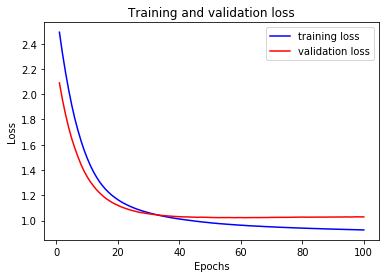

In [44]:
plt.plot(epochs, average_loss_history, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

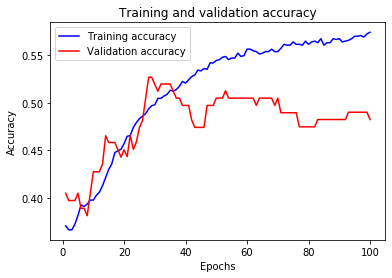

In [45]:
plt.plot(epochs, average_acc_history, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

#Performances on test set

In [46]:
 model = build_model()
 model.fit(train_data_stand_pca, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_pca, one_hot_test_labels)
  

Epoch 1/100
131/131 [==============================] - 0s 3ms/step - loss: 2.4286 - acc: 0.3511
Epoch 2/100
131/131 [==============================] - 0s 153us/step - loss: 2.2671 - acc: 0.3740
Epoch 3/100
131/131 [==============================] - 0s 164us/step - loss: 2.1284 - acc: 0.3664
Epoch 4/100
131/131 [==============================] - 0s 201us/step - loss: 2.0034 - acc: 0.3817
Epoch 5/100
131/131 [==============================] - 0s 170us/step - loss: 1.8863 - acc: 0.3893
Epoch 6/100
131/131 [==============================] - 0s 148us/step - loss: 1.7888 - acc: 0.3893
Epoch 7/100
131/131 [==============================] - 0s 165us/step - loss: 1.7028 - acc: 0.3740
Epoch 8/100
131/131 [==============================] - 0s 209us/step - loss: 1.6336 - acc: 0.3817
Epoch 9/100
131/131 [==============================] - 0s 151us/step - loss: 1.5717 - acc: 0.3740
Epoch 10/100
131/131 [==============================] - 0s 152us/step - loss: 1.5184 - acc: 0.3588
Epoch 11/100
131/131 

In [47]:
model.metrics_names

['loss', 'acc']

In [48]:
test_acc


0.29411764705882354

#Prova con LDA

##LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [51]:
train_data_stand_lda = lda.fit(train_data_stand, train_labels_dec).transform(train_data_stand)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [52]:
train_data_stand_lda.shape

(131, 2)

In [0]:
test_data_stand_lda = lda.transform(test_data_stand)

##Building Network

In [0]:
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(4, activation='relu', input_shape=(2,)))
  #model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.001, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

##Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [60]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_lda, train_labels_dec)

10

In [61]:
for train_index, test_index in skf.split(train_data_stand_lda, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   8  10  11  12  13  14  15  16  17  18  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  46  47  48  49  50  51  52  55  56  57  58  59  60
  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78  79
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96  97  98  99
 100 101 102 103 104 106 107 108 109 110 113 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130] TEST: [  7   9  19  28  45  53  54  66  80  95 105 111 112 114]
TRAIN: [  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  45  46  47  48  49  50  52  53  54  55  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117
 118 119

In [62]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [66]:
num_epochs = 100
all_acc_histories_lda = []
all_loss_histories_lda = []
all_val_acc_histories_lda = []
all_val_loss_histories_lda = []

for train_index, val_index in skf.split(train_data_stand_lda, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_lda[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_lda[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history = history.history['acc']
  all_acc_histories_lda.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories_lda.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories_lda.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories_lda.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 117 samples, validate on 14 samples
Epoch 1/100
117/117 [==============================] - 1s 5ms/step - loss: 1.3651 - acc: 0.5812 - val_loss: 1.4449 - val_acc: 0.5000
Epoch 2/100
117/117 [==============================] - 0s 182us/step - loss: 1.2821 - acc: 0.5812 - val_loss: 1.3398 - val_acc: 0.5000
Epoch 3/100
117/117 [==============================] - 0s 221us/step - loss: 1.2068 - acc: 0.5983 - val_loss: 1.2507 - val_acc: 0.5000
Epoch 4/100
117/117 [==============================] - 0s 184us/step - loss: 1.1331 - acc: 0.6239 - val_loss: 1.1544 - val_acc: 0.5714
Epoch 5/100
117/117 [==============================] - 0s 159us/step - loss: 1.0714 - acc: 0.6325 - val_loss: 1.0803 - val_acc: 0.5714
Epoch 6/100
117/117 [==============================] - 0s 166us/step - loss: 1.0162 - acc: 0.6838 - val_loss: 1.0130 - val_acc: 0.6429
Epoch 7/100
117/117 [==============================] - 0s 302us/step - loss: 0.9711 - acc: 0.6923 - val_loss: 0.9606 - val_acc: 0.6429
Epoch 8/100


In [67]:
val_data

array([[-2.46815712,  2.41613978],
       [-2.04213808, -1.20055142],
       [-2.26598031, -2.51797746],
       [-1.62561816, -1.97201226],
       [-2.12949607, -1.76064808],
       [-1.32853889, -2.05415965],
       [-1.86366758, -1.96105974],
       [ 3.1426414 ,  0.23838493],
       [ 2.76856724,  0.87507987],
       [ 3.33006485,  0.80105572],
       [ 3.99255757,  0.1366972 ],
       [ 2.79798337,  1.20174003],
       [ 1.67824072,  0.59967329]])

In [0]:
history_dict = history.history

In [69]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [70]:
len(all_acc_histories[2])

100

In [0]:
average_acc_history_lda = [np.mean([x[i] for x in all_acc_histories_lda]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history_lda = [np.mean([x[i] for x in all_loss_histories_lda]) for i in range(num_epochs)]
average_val_acc_history_lda = [np.mean([x[i] for x in all_val_acc_histories_lda]) for i in range(num_epochs)]
average_val_loss_history_lda = [np.mean([x[i] for x in all_val_loss_histories_lda]) for i in range(num_epochs)]


In [72]:
len(average_val_acc_history)

100

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

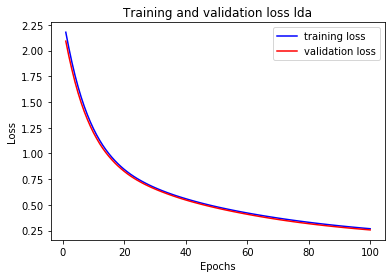

In [75]:
plt.plot(epochs, average_loss_history_lda, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history_lda, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

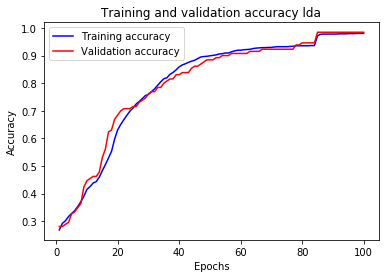

In [76]:
plt.plot(epochs, average_acc_history_lda, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_lda, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [77]:
 model = build_model()
 model.fit(train_data_stand_lda, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_lda, one_hot_test_labels)
  

Epoch 1/100
131/131 [==============================] - 1s 6ms/step - loss: 1.5186 - acc: 0.4504
Epoch 2/100
131/131 [==============================] - 0s 172us/step - loss: 1.3946 - acc: 0.4504
Epoch 3/100
131/131 [==============================] - 0s 167us/step - loss: 1.2830 - acc: 0.4504
Epoch 4/100
131/131 [==============================] - 0s 223us/step - loss: 1.1909 - acc: 0.4504
Epoch 5/100
131/131 [==============================] - 0s 151us/step - loss: 1.1125 - acc: 0.4580
Epoch 6/100
131/131 [==============================] - 0s 166us/step - loss: 1.0460 - acc: 0.4656
Epoch 7/100
131/131 [==============================] - 0s 160us/step - loss: 0.9867 - acc: 0.4656
Epoch 8/100
131/131 [==============================] - 0s 197us/step - loss: 0.9369 - acc: 0.4656
Epoch 9/100
131/131 [==============================] - 0s 153us/step - loss: 0.8962 - acc: 0.4733
Epoch 10/100
131/131 [==============================] - 0s 159us/step - loss: 0.8603 - acc: 0.4885
Epoch 11/100
131/131 

In [78]:
model.metrics_names

['loss', 'acc']

In [79]:
test_acc


0.11764705882352941

Si comporta molto bene in training e in validation ma si comporta male in test

Remove correlated features manually

# Prova remove correlated features with treshold

https://campus.datacamp.com/courses/dimensionality-reduction-in-python/feature-selection-i-selecting-for-feature-information?ex=14

In [0]:
#create a positive correlation matrix
corr_df = train_data_stand.corr().abs()

In [0]:
#create and apply mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

In [82]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])

In [0]:
tri_df = corr_df.mask(mask)

In [84]:
tri_df

,VoxelVolume,Maximum3DDiameter,MeshVolume,MajorAxisLength,Sphericity,LeastAxisLength,Elongation,SurfaceVolumeRatio,Maximum2DDiameterSlice,Flatness,SurfaceArea,MinorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,GrayLevelVariance,HighGrayLevelEmphasis,DependenceEntropy,DependenceNonUniformity,GrayLevelNonUniformity,SmallDependenceEmphasis,SmallDependenceHighGrayLevelEmphasis,DependenceNonUniformityNormalized,LargeDependenceEmphasis,LargeDependenceLowGrayLevelEmphasis,DependenceVariance,LargeDependenceHighGrayLevelEmphasis,SmallDependenceLowGrayLevelEmphasis,LowGrayLevelEmphasis,JointAverage,SumAverage,JointEntropy,ClusterShade,MaximumProbability,Idmn,JointEnergy,Contrast,DifferenceEntropy,InverseVariance,DifferenceVariance,Idn,...,10Percentile,Kurtosis,Mean,ShortRunLowGrayLevelEmphasis,GrayLevelVariance.1,LowGrayLevelRunEmphasis,GrayLevelNonUniformityNormalized,RunVariance,GrayLevelNonUniformity.1,LongRunEmphasis,ShortRunHighGrayLevelEmphasis,RunLengthNonUniformity,ShortRunEmphasis,LongRunHighGrayLevelEmphasis,RunPercentage,LongRunLowGrayLevelEmphasis,RunEntropy,HighGrayLevelRunEmphasis,RunLengthNonUniformityNormalized,GrayLevelVariance.2,ZoneVariance,GrayLevelNonUniformityNormalized.1,SizeZoneNonUniformityNormalized,SizeZoneNonUniformity,GrayLevelNonUniformity.2,LargeAreaEmphasis,SmallAreaHighGrayLevelEmphasis,ZonePercentage,LargeAreaLowGrayLevelEmphasis,LargeAreaHighGrayLevelEmphasis,HighGrayLevelZoneEmphasis,SmallAreaEmphasis,LowGrayLevelZoneEmphasis,ZoneEntropy,SmallAreaLowGrayLevelEmphasis,Coarseness,Complexity,Strength,Contrast.1,Busyness
VoxelVolume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum3DDiameter,0.821982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MeshVolume,0.999999,0.821800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MajorAxisLength,0.785606,0.964760,0.785457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sphericity,0.329751,0.678628,0.329524,0.694906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Coarseness,0.401634,0.586992,0.401370,0.546184,0.356708,0.569919,0.048602,0.813595,0.614989,0.094676,0.471734,0.598815,0.567029,0.554227,0.192052,0.605729,0.246122,0.406714,0.351606,0.669357,0.183179,0.731964,0.417524,0.077465,0.379163,0.437111,0.787425,0.182358,0.624801,0.624801,0.317491,0.119708,0.324753,0.661086,0.326758,0.468498,0.481677,0.578282,0.

In [85]:
#Find columns that meet threshold
to_drop = [c for c in tri_df.columns if any(tri_df[c]>0.70)]
to_drop

['VoxelVolume',
 'Maximum3DDiameter',
 'MeshVolume',
 'MajorAxisLength',
 'LeastAxisLength',
 'Elongation',
 'SurfaceVolumeRatio',
 'Maximum2DDiameterSlice',
 'SurfaceArea',
 'MinorAxisLength',
 'Maximum2DDiameterColumn',
 'Maximum2DDiameterRow',
 'GrayLevelVariance',
 'HighGrayLevelEmphasis',
 'DependenceEntropy',
 'DependenceNonUniformity',
 'GrayLevelNonUniformity',
 'SmallDependenceEmphasis',
 'SmallDependenceHighGrayLevelEmphasis',
 'DependenceNonUniformityNormalized',
 'LargeDependenceEmphasis',
 'LargeDependenceLowGrayLevelEmphasis',
 'DependenceVariance',
 'LargeDependenceHighGrayLevelEmphasis',
 'SmallDependenceLowGrayLevelEmphasis',
 'LowGrayLevelEmphasis',
 'JointAverage',
 'SumAverage',
 'JointEntropy',
 'ClusterShade',
 'MaximumProbability',
 'Idmn',
 'JointEnergy',
 'Contrast',
 'DifferenceEntropy',
 'InverseVariance',
 'DifferenceVariance',
 'Idn',
 'Idm',
 'Correlation',
 'Autocorrelation',
 'SumEntropy',
 'SumSquares',
 'ClusterProminence',
 'Imc2',
 'DifferenceAverage

The reason we used the mask to set half of the matrix to NA value is that we ewnt to avoid removing both features when thay have a strong correlation. 

In [0]:
#Drop those columns
train_data_stand_reduced = train_data_stand.drop(to_drop, axis=1)

In [0]:
#Drop those columns
test_data_stand_reduced = test_data_stand.drop(to_drop, axis=1)

In [88]:
train_data_stand_reduced.shape

(131, 17)

In [89]:
test_data_stand_reduced.shape

(34, 17)

In [0]:
train_data_stand_reduced = train_data_stand_reduced.to_numpy()
test_data_stand_reduced = test_data_stand_reduced.to_numpy()

In [91]:
type(train_data_stand_reduced)

numpy.ndarray

In [92]:
train_data_stand_reduced.shape

(131, 17)

funziona bene, però bisogna stare attenti a basarsi unicamente sul coefficiente di correlazione. Se y = x^2, x e y risulteranno scorrelate secondo il coeffiente di correlazione di Pearson.

##Building Network

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(10, activation='relu', input_shape=(17,)))
  #model.add(layers.Dense(5, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.01, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

##Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [95]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_reduced, train_labels_dec)

10

In [96]:
for train_index, test_index in skf.split(train_data_stand_reduced, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   8  10  11  12  13  14  15  16  17  18  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  46  47  48  49  50  51  52  55  56  57  58  59  60
  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78  79
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96  97  98  99
 100 101 102 103 104 106 107 108 109 110 113 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130] TEST: [  7   9  19  28  45  53  54  66  80  95 105 111 112 114]
TRAIN: [  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  45  46  47  48  49  50  52  53  54  55  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117
 118 119

In [97]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [116]:
type(train_data_stand_reduced)

numpy.ndarray

In [101]:
num_epochs = 100
all_acc_histories_reduced = []
all_loss_histories_reduced = []
all_val_acc_histories_reduced = []
all_val_loss_histories_reduced = []

for train_index, val_index in skf.split(train_data_stand_reduced, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_reduced[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_reduced[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history_reduced = history.history['acc']
  all_acc_histories_reduced.append(acc_history)

  loss_history_reduced = history.history['loss']
  all_loss_histories_reduced.append(loss_history)

  acc_val_history_reduced = history.history['val_acc']
  all_val_acc_histories_reduced.append(acc_val_history)

  loss_val_history_reduced = history.history['val_loss']
  all_val_loss_histories_reduced.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 117 samples, validate on 14 samples
Epoch 1/100
117/117 [==============================] - 1s 9ms/step - loss: 1.3005 - acc: 0.3504 - val_loss: 1.1231 - val_acc: 0.3571
Epoch 2/100
117/117 [==============================] - 0s 206us/step - loss: 1.1510 - acc: 0.3504 - val_loss: 1.0852 - val_acc: 0.5714
Epoch 3/100
117/117 [==============================] - 0s 235us/step - loss: 1.0750 - acc: 0.4188 - val_loss: 1.0689 - val_acc: 0.5714
Epoch 4/100
117/117 [==============================] - 0s 213us/step - loss: 1.0374 - acc: 0.4274 - val_loss: 1.0604 - val_acc: 0.5714
Epoch 5/100
117/117 [==============================] - 0s 196us/step - loss: 1.0102 - acc: 0.4615 - val_loss: 1.0525 - val_acc: 0.5714
Epoch 6/100
117/117 [==============================] - 0s 207us/step - loss: 0.9960 - acc: 0.4957 - val_loss: 1.0514 - val_acc: 0.5714
Epoch 7/100
117/117 [==============================] - 0s 169us/step - loss: 0.9810 - acc: 0.5214 - val_loss: 1.0499 - val_acc: 0.6429
Epoch 8/100


In [102]:
val_data

array([[ 7.34257050e-01,  9.68988268e-02,  3.85769839e-01,
         1.61200050e-01, -5.40961150e-01, -3.83658358e-01,
        -1.13750969e-01, -2.28591476e-01, -1.15055286e-01,
        -3.30299955e-01,  1.35982249e-01,  3.71533408e-01,
        -1.21254356e-01, -4.84378805e-01, -5.30458542e-01,
        -4.87994766e-01,  1.88481002e-01],
       [ 1.54957687e+00,  1.90539890e+00, -2.22052320e-01,
         3.87307146e-01, -5.45340485e-01, -1.01385115e+00,
        -2.73626628e-01, -6.67618363e-01, -3.33713506e-01,
        -3.30970545e-01, -1.05552128e+00, -1.16554466e+00,
         7.92773556e-01, -6.04756035e-03, -1.36103435e-01,
         2.84618093e-01, -7.68000271e-01],
       [ 1.00150735e+00, -8.58201787e-01,  3.11646964e-01,
        -1.43442573e+00, -5.49929348e-01, -9.04252402e-01,
        -5.28211743e-01, -1.20002808e-01, -3.35769175e-01,
        -3.30973760e-01, -4.42456637e-01,  2.35041057e+00,
        -1.82929991e+00,  2.68994980e-01,  2.63286133e+00,
         1.29973450e+00, -1.0

In [0]:
history_dict = history.history

In [104]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [105]:
len(all_acc_histories[2])

100

In [0]:
average_acc_history_reduced = [np.mean([x[i] for x in all_acc_histories_reduced]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history_reduced = [np.mean([x[i] for x in all_loss_histories_reduced]) for i in range(num_epochs)]
average_val_acc_history_reduced = [np.mean([x[i] for x in all_val_acc_histories_reduced]) for i in range(num_epochs)]
average_val_loss_history_reduced = [np.mean([x[i] for x in all_val_loss_histories_reduced]) for i in range(num_epochs)]


In [107]:
len(average_val_acc_history_reduced)

100

In [108]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 10)                180       
_________________________________________________________________
dense_64 (Dense)             (None, 3)                 33        
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

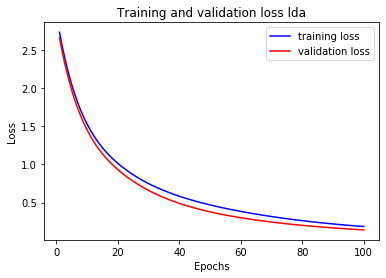

In [111]:
plt.plot(epochs, average_loss_history_reduced, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history_reduced, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

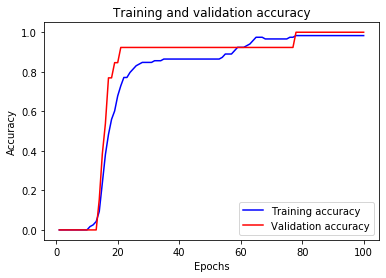

In [112]:
plt.plot(epochs, average_acc_history_reduced, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_reduced, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [113]:
 model = build_model()
 model.fit(train_data_stand_reduced, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_reduced, one_hot_test_labels)
  

Epoch 1/100
131/131 [==============================] - 1s 9ms/step - loss: 1.1641 - acc: 0.4122
Epoch 2/100
131/131 [==============================] - 0s 176us/step - loss: 1.0482 - acc: 0.4427
Epoch 3/100
131/131 [==============================] - 0s 175us/step - loss: 0.9928 - acc: 0.5267
Epoch 4/100
131/131 [==============================] - 0s 173us/step - loss: 0.9662 - acc: 0.5725
Epoch 5/100
131/131 [==============================] - 0s 170us/step - loss: 0.9504 - acc: 0.5802
Epoch 6/100
131/131 [==============================] - 0s 167us/step - loss: 0.9380 - acc: 0.5573
Epoch 7/100
131/131 [==============================] - 0s 183us/step - loss: 0.9281 - acc: 0.5954
Epoch 8/100
131/131 [==============================] - 0s 194us/step - loss: 0.9203 - acc: 0.5954
Epoch 9/100
131/131 [==============================] - 0s 181us/step - loss: 0.9110 - acc: 0.5802
Epoch 10/100
131/131 [==============================] - 0s 199us/step - loss: 0.9018 - acc: 0.5954
Epoch 11/100
131/131 

In [114]:
model.metrics_names

['loss', 'acc']

In [115]:
test_acc


0.17647058823529413

Si comporta molto bene in training e in validation ma si comporta male in test